# Convert Published kv450 Data Vectors to SACC

Notes on these files and the download link to the original tarball here: 
http://kids.strw.leidenuniv.nl/cs2018/kv450_sheardata_README.txt

In [1]:
import numpy as np
import sacc
import pandas as pd
import h5py as h
import matplotlib.pyplot as plt

In [2]:
data_dir = '/global/cscratch1/sd/elp25/txpipe-reanalysis/kv450/data/KV450_COSMIC_SHEAR_DATA_RELEASE/'

In [18]:
data_dir = '/global/projecta/projectdirs/lsst/groups/WL/projects/wl-txpipe-hack/KIDS/KiDS-450_COSMIC_SHEAR_DATA_RELEASE/'

In [19]:
!ls {data_dir}/

COV_MAT  DATA_VECTOR  Nz_CC  Nz_DIR  cosmic_shear_readme


## Redshift Distributions

In [21]:
!ls {data_dir}/REDSHIFT_DISTRIBUTIONS/

ls: cannot access '/global/projecta/projectdirs/lsst/groups/WL/projects/wl-txpipe-hack/KIDS/KiDS-450_COSMIC_SHEAR_DATA_RELEASE//REDSHIFT_DISTRIBUTIONS/': No such file or directory


In [5]:
nz = {}
binnum = 0
for binrange in ['z0.1t0.3','z0.3t0.5','z0.5t0.7','z0.7t0.9','z0.9t1.2']:
    nz['bin'+str(binnum)] = pd.read_table(data_dir+'/REDSHIFT_DISTRIBUTIONS/Nz_DIR/Nz_DIR_Mean/Nz_DIR_'+binrange+'.asc',names=['z','nz'],skiprows=1,
                                         delim_whitespace=True)
    binnum+=1

Text(0.5, 1.0, 'N(z)')

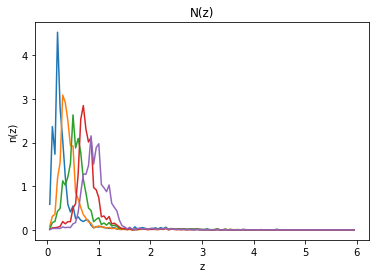

In [6]:
for binnum in range(5):
    plt.plot(nz['bin'+str(binnum)]['z'],nz['bin'+str(binnum)]['nz'],label='bin'+str(binnum))
plt.xlabel('z')
plt.ylabel('n(z)')
plt.title('N(z)')

In [7]:
shear_cat = h.File('/global/cscratch1/sd/elp25/txpipe-reanalysis/kv450/data/DR3/shear_catalog_kids450_nonmetacal.h5', 'r')
z = shear_cat['shear/mean_z'].value
Nsource = []
Zmin = [0.1,0.3,0.5,0.7,0.9]
Zmax = [0.3,0.5,0.7,0.9,1.2]
for i in range(5):
    Nsource.append(len(z[(z>=Zmin[i])*(z<Zmax[i])]))
shear_cat.close()
print(Nsource)

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  from ipykernel import kernelapp as app


[3769174, 3249574, 2941861, 2640577, 1183737]


In [8]:
nz['bin'+str(binnum)]['nz']

0      0.007004
1      0.033195
2      0.033672
3      0.034620
4      0.034786
         ...   
114    0.000000
115    0.000000
116    0.000000
117    0.000000
118    0.000000
Name: nz, Length: 119, dtype: float64

In [9]:
bin_edges = nz['bin'+str(binnum)]['z']
bin_mids = np.array([(bin_edges[i]-bin_edges[i+1])/2+bin_edges[i] for i in range(len(bin_edges)-1)])
bin_mids = np.append(bin_mids,[bin_mids[len(bin_mids)-1]+0.05])

### Convert to TXPipe Format

In [10]:
f = h.File('/global/cscratch1/sd/elp25/txpipe-reanalysis/kv450/data/photoz_stack.hdf5', 'w')
f.create_group('n_of_z')

# lenses
g1 = f.create_group('n_of_z/lens')
#g1.create_dataset('z', data=desy1[7].data['Z_MID'], dtype=desy1[7].data['Z_MID'].dtype)
#for i in range(1):
#    g1.create_dataset('bin_'+str(i), data=desy1[7].data['BIN'+str(i+1)], dtype=desy1[7].data['BIN'+str(i+1)].dtype)
g1.attrs['nbin'] = 0
#g1.attrs['nz'] = len(desy1[7].data['Z_MID'])
#for i in range(1):
#    g1.attrs['count_'+str(i)] = 100000.0

# sources
g2 = f.create_group('n_of_z/source')
g2.create_dataset('z', data=bin_mids, dtype=bin_mids.dtype)
for i in range(5):
    g2.create_dataset('bin_'+str(i), data=nz['bin'+str(i)]['nz'], dtype=nz['bin'+str(binnum)]['nz'].dtype)
g2.attrs['nbin'] = 5
g2.attrs['nz'] = bin_mids
for i in range(5):
    g2.attrs['count_'+str(i)] = float(Nsource[i])
    
f.create_group('n_of_z/source2d')
f.create_group('provenance')

f.close()

In [11]:
#!rm /global/cscratch1/sd/elp25/txpipe-reanalysis/kv450/data/photoz_stack.hdf5

In [12]:
!cp /global/cscratch1/sd/elp25/txpipe-reanalysis/kv450/data/photoz_stack.hdf5 /global/cscratch1/sd/elp25/TXPipe/data/kv450/outputs

In [37]:
f = h.File('/global/cscratch1/sd/elp25/txpipe-reanalysis/kv450/data/photoz_stack.hdf5', 'r')
f['n_of_z'].keys()

<KeysViewHDF5 ['lens', 'source', 'source2d']>

In [38]:
f.close()

## Covariance

In [39]:
!ls {data_dir}/COV_MAT

Cov_mat_all_scales.txt	xipmcutcov_KV450_analytic_inc_m.dat


In [40]:
cov = pd.read_table(data_dir+'/COV_MAT/xipmcutcov_KV450_analytic_inc_m.dat',names=['i','j','Cov(i,j)'],skiprows=1)

In [41]:
len(cov)

38025

In [42]:
cov_matrix = np.ones((195,195))
for index, row in cov.iterrows():
    cov_matrix[int(row['i'])-1][int(row['j'])-1] = row['Cov(i,j)']

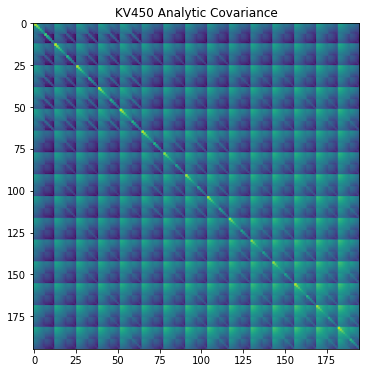

In [43]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(6,6))
plt.imshow(cov_matrix,norm=LogNorm())
plt.title('KV450 Analytic Covariance')
plt.show()

## Data Vector

In [13]:
data_vecs = pd.read_csv(data_dir+'/DATA_VECTOR/KV450_xi_pm_tomographic_data_vector.dat',
            names=['i','theta','xi_p/m(i)','(p=1, m=2)','itomo','jtomo'],
                     delimiter='	',skiprows=1)

In [14]:
data_vecs.head()

,i,theta,xi_p/m(i),"(p=1, m=2)",itomo,jtomo
0,1,0.78613,0.000020,1,1,1
1,2,1.59960,0.000082,1,1,1
2,3,3.25350,0.000049,1,1,1
3,4,6.62300,0.000012,1,1,1
4,5,13.49300,-0.000005,1,1,1


In [17]:
data_vecs.theta.values

array([  0.78613,   1.5996 ,   3.2535 ,   6.623  ,  13.493  ,  27.385  ,
        55.541  ,   6.623  ,  13.493  ,  27.385  ,  55.541  , 112.61   ,
       223.72   ,   0.78613,   1.5996 ,   3.2535 ,   6.623  ,  13.493  ,
        27.385  ,  55.541  ,   6.623  ,  13.493  ,  27.385  ,  55.541  ,
       112.61   , 223.72   ,   0.78613,   1.5996 ,   3.2535 ,   6.623  ,
        13.493  ,  27.385  ,  55.541  ,   6.623  ,  13.493  ,  27.385  ,
        55.541  , 112.61   , 223.72   ,   0.78613,   1.5996 ,   3.2535 ,
         6.623  ,  13.493  ,  27.385  ,  55.541  ,   6.623  ,  13.493  ,
        27.385  ,  55.541  , 112.61   , 223.72   ,   0.78613,   1.5996 ,
         3.2535 ,   6.623  ,  13.493  ,  27.385  ,  55.541  ,   6.623  ,
        13.493  ,  27.385  ,  55.541  , 112.61   , 223.72   ,   0.78613,
         1.5996 ,   3.2535 ,   6.623  ,  13.493  ,  27.385  ,  55.541  ,
         6.623  ,  13.493  ,  27.385  ,  55.541  , 112.61   , 223.72   ,
         0.78613,   1.5996 ,   3.2535 ,   6.623  , 

In [46]:
# 7 points for xi_p 
# 6 points for xi_m

In [47]:
def get_theta_xi(i,j,s):
    data_vecs_bin = data_vecs[(data_vecs.itomo==i) & (data_vecs.jtomo==j) & (data_vecs['(p=1, m=2)']==s)]
    return data_vecs_bin

In [49]:
len(bin_mids)

119

In [50]:
len(nz['bin'+str(i-1)]['nz'])

119

## SACC 

In [51]:
sacc_data = sacc.Sacc()

n_srcs = 5

# nz_lens
#dndz = data['nz_lens'].read()
#for i in range(1, n_lens+1):
#    sacc_data.add_tracer('NZ', 'lens%d' % (i-1), dndz['Z_MID'], dndz['BIN%d' % i])

# nz_src
for i in range(1, n_srcs+1):
    sacc_data.add_tracer('NZ', 'source_%d' % (i-1), bin_mids, nz['bin'+str(i-1)]['nz'])

# xip

for i in range(1, n_srcs+1):
    for j in range(i, n_srcs+1):
        
        bin_data = get_theta_xi(i,j,1)
        theta = bin_data.theta
        xip = bin_data['xi_p/m(i)']
        
        #theta_min = min(bin_data.theta)
        #theta_max = max(bin_data.theta)

        #ij_msk = (xip['BIN1'] == i) & (xip['BIN2'] == j)
        #xip_ij = xip[ij_msk]
        #msk = (xip_ij['ANG'] > theta_min) & (xip_ij['ANG'] < theta_max)

        #tot_msk.extend(msk.tolist())

        sacc_data.add_theta_xi(
            'galaxy_shear_xi_plus',
            'source_%d' % (i-1),
            'source_%d' % (j-1),
            theta,
            xip)

for i in range(1, n_srcs+1):
    for j in range(i, n_srcs+1):
        
        bin_data = get_theta_xi(i,j,2)
        theta = bin_data.theta
        xip = bin_data['xi_p/m(i)']
        
        #theta_min = min(bin_data.theta)
        #theta_max = max(bin_data.theta)

        #ij_msk = (xip['BIN1'] == i) & (xip['BIN2'] == j)
        #xip_ij = xip[ij_msk]
        #msk = (xip_ij['ANG'] > theta_min) & (xip_ij['ANG'] < theta_max)

        #tot_msk.extend(msk.tolist())

        sacc_data.add_theta_xi(
            'galaxy_shear_xi_minus',
            'source_%d' % (i-1),
            'source_%d' % (j-1),
            theta,
            xip)

# covmat

sacc_data.add_covariance(cov_matrix)

sacc_data.save_fits('kv450_cosmicshear_sacc_data.fits', overwrite=True)

In [53]:
!cp kv450_cosmicshear_sacc_data.fits /global/cscratch1/sd/elp25/TXPipe/data/kv450/outputs